In [1]:
!pip install seaborn

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import cv2
 
import warnings
warnings.filterwarnings('ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
labels = ['battery' , 'biological' , 'carboard' , 'cloths' , 'glass', 'metal' , 'paper' , 'plastic' , 'shoes']

In [3]:
data = tf.keras.utils.image_dataset_from_directory('final_data' ,batch_size = 32, image_size = (48,48))

Found 8371 files belonging to 9 classes.


In [4]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
 
train_generator = gen.flow_from_directory(
    # data, # dataframe
    directory = './final_data', # images data path / folder in which images are there
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
 
 
validation_generator = gen.flow_from_directory(
    # data # dataframe
    directory = './final_data', # images data path / folder in which images are there
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 6699 images belonging to 9 classes.
Found 1672 images belonging to 9 classes.


In [7]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size


(32, 331, 331, 3)

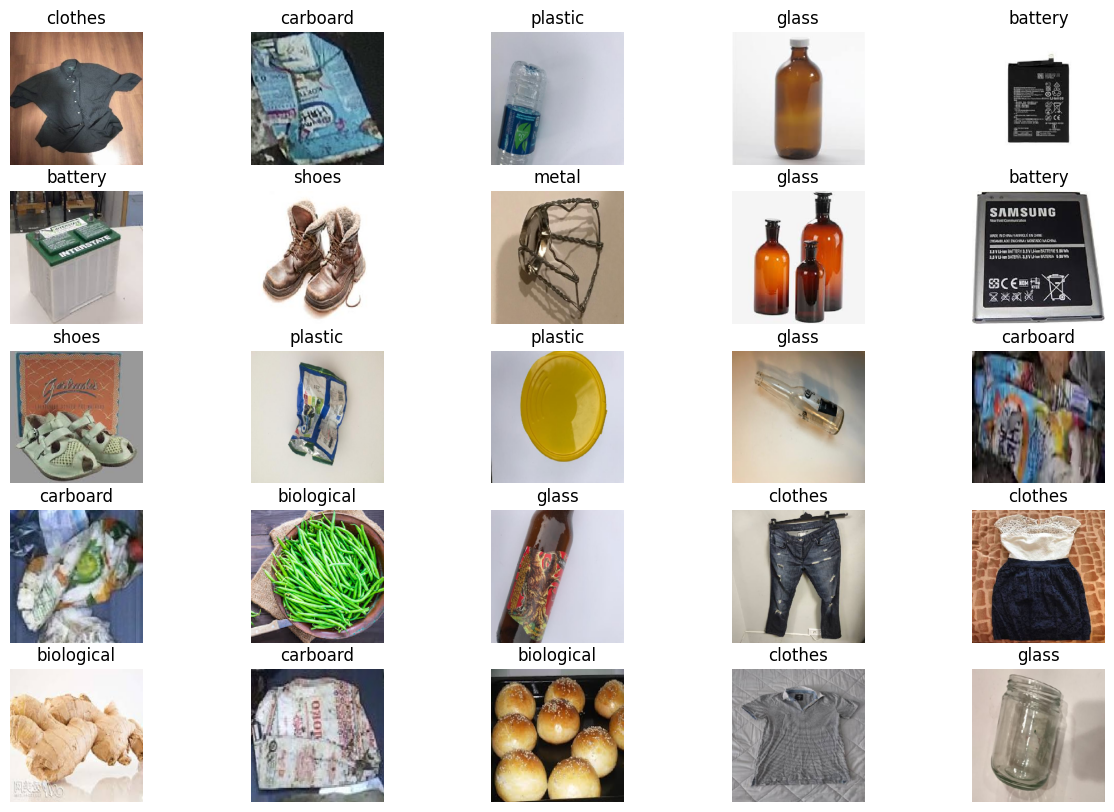

In [8]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list


def plot_images(img, labels):
	plt.figure(figsize=[15, 10])
	for i in range(25):
		plt.subplot(5, 5, i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
		plt.axis('off')

plot_images(x,y)


In [9]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([ 
		base_model, 
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(9, activation='softmax')
	])


In [10]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [11]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
										min_delta=0.001,
										restore_best_weights=True)
# early stopping call back
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=10,
					callbacks=[early])




Epoch 1/10
209/209 [==============================] - 280s 1s/step - loss: 0.5505 - accuracy: 0.8202 - val_loss: 0.3494 - val_accuracy: 0.8906
Epoch 2/10
209/209 [==============================] - 251s 1s/step - loss: 0.2557 - accuracy: 0.9165 - val_loss: 0.3204 - val_accuracy: 0.8930
Epoch 3/10
209/209 [==============================] - 246s 1s/step - loss: 0.1776 - accuracy: 0.9436 - val_loss: 0.4105 - val_accuracy: 0.8780
Epoch 4/10
209/209 [==============================] - 246s 1s/step - loss: 0.1427 - accuracy: 0.9520 - val_loss: 0.4208 - val_accuracy: 0.8936
Epoch 5/10
209/209 [==============================] - 247s 1s/step - loss: 0.1121 - accuracy: 0.9633 - val_loss: 0.5674 - val_accuracy: 0.8624
Epoch 6/10
209/209 [==============================] - 249s 1s/step - loss: 0.0999 - accuracy: 0.9696 - val_loss: 0.4180 - val_accuracy: 0.8870
Epoch 7/10
209/209 [==============================] - 248s 1s/step - loss: 0.0660 - accuracy: 0.9795 - val_loss: 0.6964 - val_accuracy: 0.8528

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9838008284568787\nValidation Accuracy: 0.8707932829856873')

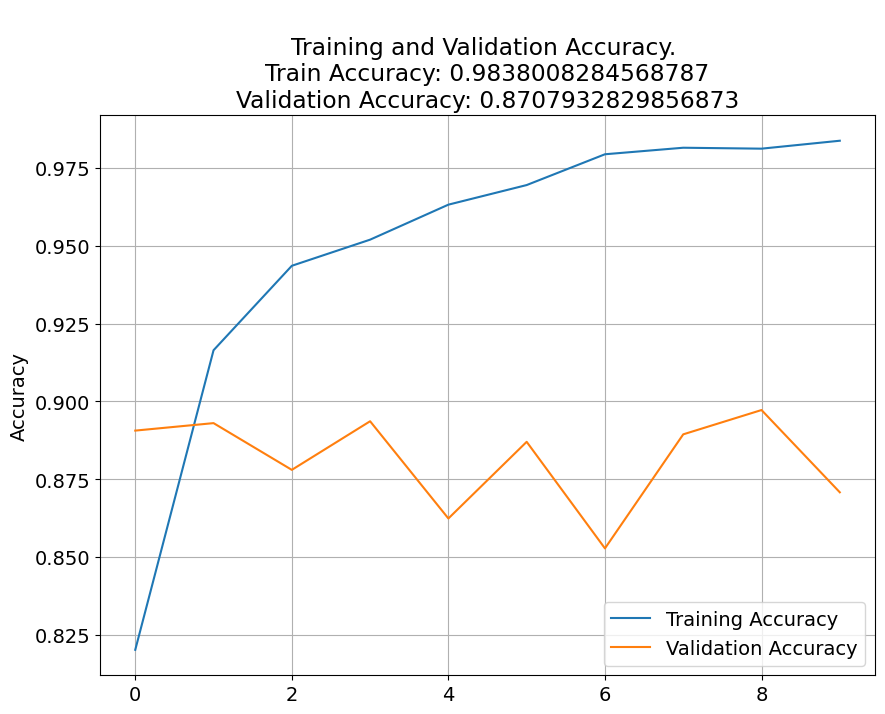

In [12]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


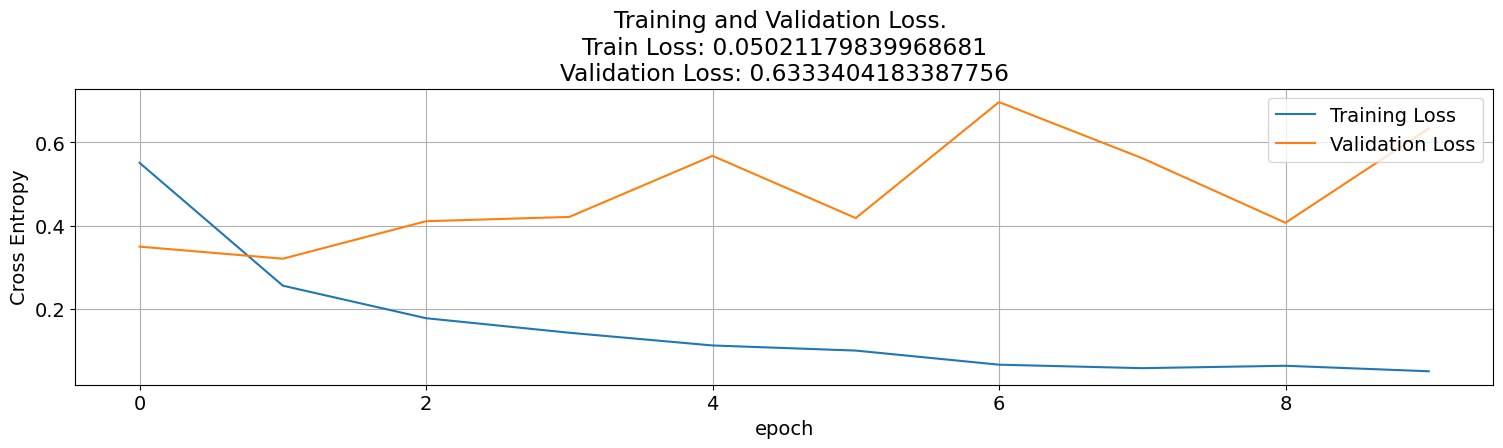

In [13]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [14]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
 
print("Loss: ",accuracy_score[0])

53/53 [==============================] - 52s 980ms/step - loss: 0.6210 - accuracy: 0.8756
[0.6210410594940186, 0.8755980730056763]
Accuracy: 87.5598%
Loss:  0.6210410594940186


In [15]:
model.save("Model_2.h5")


In [35]:

img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

1/1 [==============================] - 9s 9s/step


In [36]:
prediction

array([[6.7338792e-06, 2.1435858e-06, 7.4099819e-04, 8.2192258e-08,
        1.5076122e-05, 4.2367778e-06, 1.0421693e-03, 9.9818820e-01,
        3.0668500e-07]], dtype=float32)

In [16]:
hist_=pd.DataFrame(history.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.550547,0.820159,0.349424,0.890625
1,0.255655,0.916454,0.320448,0.893029
2,0.177576,0.943603,0.410460,0.878005
3,0.142686,0.952002,0.420754,0.893630
4,0.112148,0.963252,0.567378,0.862380
5,0.099874,0.969552,0.418009,0.887019
6,0.065998,0.979451,0.696448,0.852764
7,0.057655,0.981551,0.561670,0.889423
8,0.063402,0.981251,0.406721,0.897236
9,0.050212,0.983801,0.633340,0.870793


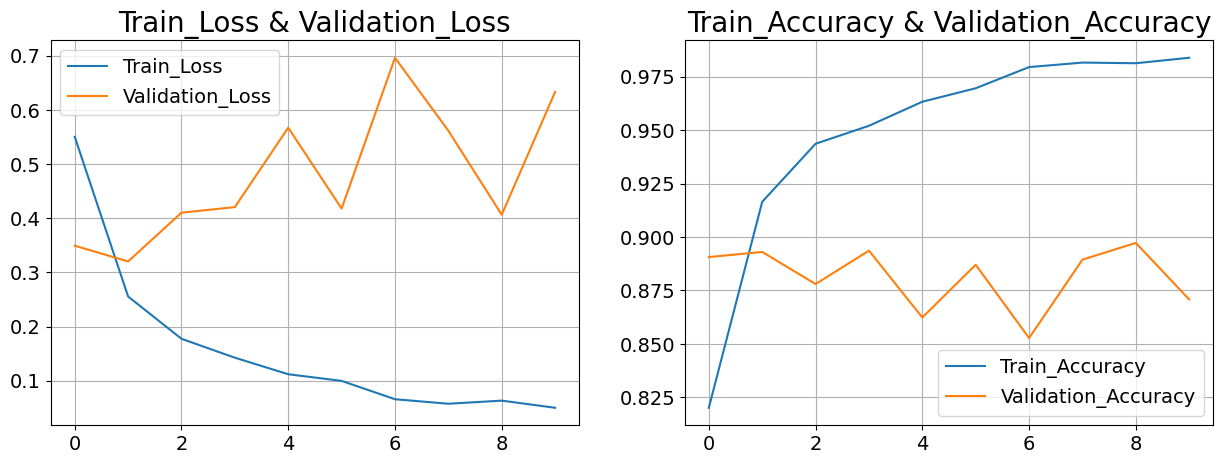

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()